# Load and plot Unsmoothed level-2 SSH

Date: December 1, 2023

Disclaimer: This tutorial provides a quick guide for loading and visualizing the SWOT Level-2 SSH data Unsmoothed (250m posting) subcollection. As of the time of writing, please note that the unsmoothed product lacks the same comprehensive error corrections found in the Basic and Expert products. Notably, the cross-swath bias, atmospheric corrections, tidal corrections, sea state bias, mean sea surface, etc., are not removed. 

The code below addresses the cross-swath bias by applying a linear detrend along long (1000km) segments. However, this approach is ad hoc and may introduce significant errors in coastal and inland waters if the available data segments are shorter than ~1000km due to land/ice cover. Please exercise caution when using this method.

This notebook requires the swot_ssh_utils.py library in this package [https://github.com/SWOT-community/SWOT-OpenToolkit/blob/main/src/swot_ssh_utils.py]. 

It also requires the newer mean sea surface to provide a more accurate bias removal. The details of the MSS removal can be found here: https://github.com/SWOT-community/SWOT_SIO/tree/main/examples/replace_mss. swot_ssh_utils.py will automatically download the mss_sio_32.1_WGS84.nc into ../data folder if it does not exists. 

In [12]:
# -*- coding: utf-8 -*-
#add the path to the swot library
import sys
sys.path.append('../src/')
import swot_ssh_utils as swot

#turn off warnings
import warnings
warnings.filterwarnings("ignore")


## Load and plot pass 13 in the Northeast Pacific region

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import swot_ssh_utils as swot

# initialize the class SSH_L2
dd=swot.SSH_L2()

# replace the unsmoothed file here
folder="/mnt/flow/swot/KaRIn/SWOT_L2_LR_SSH_1.1/"
fn = folder+"SWOT_L2_LR_SSH_Unsmoothed_478_013_20230402T073744_20230402T082850_PIA1_01.nc" 

# load data into the class
# the lat_bounds keyword is used to subset the data
# the return is dd.left and dd.right, which correspond to the left and right swath
dd.load_data(fn,lat_bounds=[30,42],)

# print the variables in the file
print(dd.left)


Load unsmoothed data to self.left and self.right
Subset data between latitude bounds  [30, 42]
<xarray.Dataset>
Dimensions:                                (num_lines: 5691, num_pixels: 240)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 na...
    longitude                              (num_lines, num_pixels) float64 na...
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/16)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    latitude_uncert                        (num_lines, num_pixels) float32 ...
    longitude_uncert                       (num_lines, num_pixels) float32 ...
    polarization_karin                     (num_lines) object ...
    ssh_karin_2                            (num_lines, num_pixels) float64 ...
    ...                                     ...
    sig0_karin_uncert                      (num_lines, num

## Visualize the unsmoothed SSH

Most likely you need to modify the following line in the code to fit your region. 

    msk=(lat[:,10]>30)&(lat[:,10]<38.7)

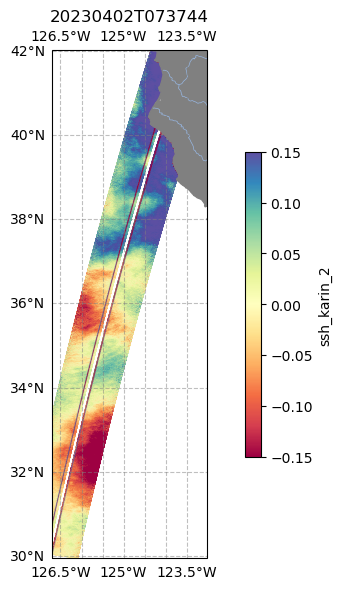

In [20]:
# Create a map using cartopy

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

# add land, rivers, lakes, and coastlines
land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='gray')
ax.add_feature(land)
ax.add_feature(cfeature.RIVERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, linewidth=0.5)

# add states and provinces
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

# visualize the data seperately for left and right swaths
for tmp in [dd.left,dd.right]:
    #find data points in the open ocean (flag==0)
    #This flag is not always reliable, but it is the best we have for now
    surf=tmp.ancillary_surface_classification_flag==0

    # There is a flag ssh_karin_2_qual that can be used to filter out bad data
    # But it is not always reliable yet in the current products (Dec 1, 2023)
    # This flag is not yet used in the code below, but you can uncomment the following line to check it. 
    #qc_flag=tmp.ssh_karin_2_qual==0 # flag==0 means good data
    
    #mask out non-ocean and bad data
    dtm=np.where(surf,tmp.ssh_karin_2.data,np.nan) 
    
    dtm=dtm-np.nanmin(dtm.flatten()) # this can remove the cross-swath bias 
    
    lon,lat=tmp.longitude.data,tmp.latitude.data
    
    m=~np.isnan(lon+lat).flatten() # mask out the nan values
    
    mss=swot.get_mss22(lon,lat) # get the mean sea surface
    dtm-=mss # remove the mean sea surface 
    
    # the following line find the latitude limit
    # to bound the area for along-track mean removal
    # you can change the bounds to get a better fit for your region. 
    # The 10th column of the lat array is used as an approximate. 
    msk=(lat[:,10]>30)&(lat[:,10]<38.7)
    
    # remove the along-track mean, the ad hoc way of removing cross-swath bias
    dtm=dtm - np.nanmean(dtm[msk,:],axis=0)[np.newaxis,:] 
    
    # plot the data using scatter 
    cax=ax.scatter(lon.flatten()[m], lat.flatten()[m], 
                   c=dtm.flatten()[m], s=0.05, vmin=-0.15,vmax=0.15, 
                   cmap=plt.cm.Spectral ,transform=ccrs.PlateCarree())
# add colorbar and gridlines
gl = ax.gridlines(draw_labels=True, color='gray', 
                  alpha=0.5, linestyle='--')
cbar = plt.colorbar(cax, ax=ax,shrink=0.6)
# remove the right side ylabels
gl.right_labels = False
cbar.set_label('ssh_karin_2')
ax.set_title(fn.split('/')[-1].split('_')[7])

# set the extent of the map
lonmin,lonmax,latmin,latmax=np.nanmin(lon),np.nanmax(lon),np.nanmin(lat),np.nanmax(lat)
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=ccrs.PlateCarree())

plt.tight_layout()